In [1]:
import pandas as pd
import numpy as np
import os, re
data_path = "C:/Users/SpiffyApple/Documents/USC/OwnResearch/marketShare"

import matplotlib.pyplot as plt
%matplotlib inline
jet = plt.get_cmap('jet')

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.regression.linear_model import WLS
import seaborn as sns
from statsmodels.stats.weightstats import ttest_ind

import geopandas as gpd
from geopandas.tools import sjoin
from shapely.geometry import Point

import itertools

In [2]:
#convenience function
def toLatex(tmpDF, file_name, reg=False):
    with open("/".join([data_path,file_name]), 'w+') as f:
        if reg==False:
            f.write(tmpDF.to_latex())
        if reg:
            f.write(tmpDF.as_latex())
    return(tmpDF)

def toExcel(tmpDF, file_name):
    tmpDF.to_excel("/".join([data_path,file_name]))
    return(tmpDF)

In [3]:
def findcol(keyphrase):
    #convenience function
    return df.columns[df.columns.str.lower().str.contains(keyphrase)]

# Wake County Data

Assessor data come from [here](http://www.wakegov.com/tax/realestate/redatafile/Pages/default.aspx)


Land use [codes](http://www.wakegov.com/tax/realestate/Documents/CodeDescriptions.pdf)

Lat/lon data on parcels come from [NC OneMap](https://services.nconemap.gov/ncom-parcels-dd.htm). Lat/lon data are merged with Block Group data from US Census [Tiger](https://www2.census.gov/geo/pvs/tiger2010st/37_North_Carolina/37183/)

### Load data

In [4]:
df = pd.read_excel("/".join([data_path, 'realestdata07032020.xlsx']))
print("Initial data size: %d" %df.shape[0])

Initial data size: 412624


### Clean up data

In [5]:
# Select only residential properties:
df.drop((df.loc[df.TYPE_AND_USE > 10].index),inplace=True)
#df.columns

In [6]:
# drop observations with missing type_and_use
df.drop(df.loc[df.TYPE_AND_USE.isnull()].index,inplace=True)

In [7]:
df.shape[0]

335199

In [8]:
df.columns

Index(['OWNER1', 'OWNER2', 'Mailing_address1', 'Mailing_Address2',
       'Mailing_Address3', 'REAL_ESTATE_ID', 'CARD_NUMBER', 'NUMBER_OF_CARDS',
       'Street_Number', 'Street_Prefix', 'Street_Name', 'Street_Type',
       'Street_Suffix', 'Planning_Jurisdiction', 'Street_Misc', 'Township',
       'Fire_District', 'Land_Sale_Price', 'Land_Sale_Date', 'Zoning',
       'Deeded_Acreage', 'Total_sale_Price', 'Total_Sale_Date',
       'Assessed_Building_Value', 'Assessed_Land_Value',
       'Parcel_Identification', 'Special_District1', 'Special_District2',
       'Special_District3', 'BILLING_CLASS', 'PROPERTY_DESCRIPTION',
       'Land_classification', 'DEED_BOOK', 'DEED_PAGE', 'Deed_Date', 'VCS',
       'PROPERTY_INDEX', 'Year_Built', 'NUM_of_Rooms', 'UNITS', 'HEATED_AREA',
       'UTILITIES', 'Street_pavement', 'TOPOGRAPHY', 'Year_of_Addition',
       'Effective_year', 'Remodeled_Year', 'Special_Write_In', 'Story_Height',
       'DESIGN_STYLE', 'Foundation_Basement', 'Foundation_Basemen

In [9]:
df.Parcel_Identification.iloc[:5]

18    1714.20 81 7084 000
19    1722.11 65 9239 000
20    0783.09 06 3610 000
21    1784.19 52 6263 000
22    0783.06 29 5049 000
Name: Parcel_Identification, dtype: object

In [10]:
df[['Parcel_Identification','OWNER1','Street_Number', 'Street_Prefix', 'Street_Name','Township']].iloc[0]

Parcel_Identification               1714.20 81 7084 000
OWNER1                   MICKENS, ROBERT EARL & ANNIE M
Street_Number                                      2457
Street_Prefix                                       NaN
Street_Name                                      BERTIE
Township                                              1
Name: 18, dtype: object

# Get property holdings

- maybe get rid of City/County owners
- some residences don't have units despite being single-residence even multi-family

In [11]:
cntsbyownr = df.groupby('OWNER1').UNITS.sum()

In [12]:
cntsbyownr.sort_values(ascending=False).head(n=10)

OWNER1
CSP COMMUNITY OWNER LLC                1704
HOUSING AUTH CITY OF RALEIGH           1160
POAA II LLC                             780
CAMDEN SUMMIT PARTNERSHIP LP            758
MID AMERICA APARTMENTS LP               644
NORTH RIDGE APTS LLC                    600
NCSU                                    589
PRIII RTP8 (WALNUT CREEK) OWNER LLC     576
CMF 15 PORTFOLIO LLC                    574
3110 HIDDEN POND DRIVE LLC              552
Name: UNITS, dtype: int64

In [13]:
cntsbyownr.sort_values(ascending=False).tail(n=10)

OWNER1
SPENCER, RYAN A & ABIGAIL             0
UPTON, DAVID MARSHALL                 0
REID, SEAN PATRICK & BRITTANY LYNN    0
NAYYAR, VISHESH & MAYA SIRUR          0
BABAN, NAUSHERUAN K                   0
HENRY, PHILLIP                        0
HUNTLEY, ROBERT & AMIE                0
CHAN, ERIC Y & MARIA B                0
ELDRED, MICHAEL G & LETHA P           0
ROGERS, JUSTIN J. & SUSAN E.          0
Name: UNITS, dtype: int64

In [14]:
df.loc[df.UNITS==0, ['NUM_of_Rooms','UNITS','TYPE_AND_USE', 'Total_sale_Price','Land_Sale_Date', 'PROPERTY_DESCRIPTION','CITY','DESIGN_STYLE']]

,NUM_of_Rooms,UNITS,TYPE_AND_USE,Total_sale_Price,Land_Sale_Date,PROPERTY_DESCRIPTION,CITY,DESIGN_STYLE
319,0,0,3.0,0,NaT,LO2 REC J & H ADAMS LLC ETAL BM2001-00825,NaN,A
1463,0,0,5.0,0,NaT,HOMELAND SPLIT,RAL,A
2673,0,0,9.0,0,NaT,LO1 HILLSTONE CAMERON VILLAGE BM2018-00247,RAL,A
3099,0,0,1.0,841500,NaT,LO55 HIGHMOUNT SUB,RAL,NaN
3886,0,0,6.0,157000,NaT,LO1 JONES ST.,WAK,A
...,...,...,...,...,...,...,...,...
408427,0,0,1.0,555500,NaT,LO68 Oak Pointe PH2 BM2019-01848,APE,NaN
408430,0,0,1.0,536000,NaT,LO70 Oak Pointe PH2 BM2019-01848,APE,NaN
411773,0,0,1.0,274000,NaT,LO45 Downton Square Townhomes BM2019-01749,HOL,NaN
411774,0,0,1.0,0,NaT,LO46 Downton Square Townhomes BM2019-01749,HOL,NaN


In [15]:
m = df.PROPERTY_DESCRIPTION.isnull().sum()
print("Number of observations without a description: %d" %m)

Number of observations without a description: 31


In [16]:
cond = df.PROPERTY_DESCRIPTION.notnull()
cond2 = df.loc[cond].PROPERTY_DESCRIPTION.str.contains('Downton Square Townhomes BM2019-01749')
df.loc[cond & cond2,['NUM_of_Rooms','UNITS','TYPE_AND_USE', 'Total_sale_Price', 'PROPERTY_DESCRIPTION','CITY','DESIGN_STYLE']]

,NUM_of_Rooms,UNITS,TYPE_AND_USE,Total_sale_Price,PROPERTY_DESCRIPTION,CITY,DESIGN_STYLE
411770,0,1,1.0,299000,LO42 Downton Square Townhomes BM2019-01749,HOL,C
411771,0,1,1.0,270000,LO43 Downton Square Townhomes BM2019-01749,HOL,C
411772,0,1,1.0,0,LO44 Downton Square Townhomes BM2019-01749,HOL,C
411773,0,0,1.0,274000,LO45 Downton Square Townhomes BM2019-01749,HOL,NaN
411774,0,0,1.0,0,LO46 Downton Square Townhomes BM2019-01749,HOL,NaN
411775,0,0,1.0,0,LO47 Downton Square Townhomes BM2019-01749,HOL,NaN


In [17]:
df.loc[(df.TYPE_AND_USE == 1) & (df.UNITS>1), ['UNITS','PROPERTY_DESCRIPTION','OWNER1','DESIGN_STYLE']]

,UNITS,PROPERTY_DESCRIPTION,OWNER1,DESIGN_STYLE
41032,2,504 N PERSON STREET,COLEMAN GROUP INC THE,A
44200,2,LO3 KINGDOM TRUST COMP & BELLAMY RCMB BM2018-0...,"BELLAMY, DANIEL & QUANTINNA",A
57115,3,LO2 CAMERON PK BL18 BM1915-19,"EWEN, TODD J. & ILINA D.",A
59151,4,HINNICUTT PROPERTY,"BRONSTEIN, RICHARD S & JUANITA R",A
61813,2,LO441 BLOOMSBURY SUB,"MCCOY, EARLE E & LORRY",A
65139,2,LO127 BOYLAN HEIGHTS BM1885-00114,"CLAY, ADRYON H",A
66240,3,LO127 BATTERY HGTS,"HADDON, ERIC MARTIN",A
70512,2,LO7 TIMBERLAKE LANDS,"BARAKAT, NABEGH",A
156828,2,MASTER CARD CAVANAUGH GARDEN HMES CONDOS,CAVANAUGH GARDEN HOMES,D
228155,6,LO121 WINDWARD DOWNS PH1 BM1998-1978,"PIDIKITI, SREERAMA MURTHY",A


In [18]:
df[df.OWNER1.str.contains("COLEMAN GROUP INC")]

,OWNER1,OWNER2,Mailing_address1,Mailing_Address2,Mailing_Address3,REAL_ESTATE_ID,CARD_NUMBER,NUMBER_OF_CARDS,Street_Number,Street_Prefix,...,Land_Deferred_code,Land_Deferred_Amount,Historic_Deferred_code,Historic_Deferred_Amount,RECYCLED_UNITS,Disq_and_Qual_flag,Land_Disq_and_Qual_flag,TYPE_AND_USE,PHYSICAL_CITY,PHYSICAL_ZIP_CODE
13127,COLEMAN GROUP INC THE,NaN,115 S SAINT MARYS ST,RALEIGH NC 27603-1699,NaN,14540,1,1,118,S,...,NaN,0,NaN,0,7,A,NaN,5.0,RALEIGH,27603.0
13236,COLEMAN GROUP INC THE,NaN,115 S SAINT MARYS ST,RALEIGH NC 27603-1699,NaN,14660,1,1,522,NaN,...,NaN,0,NaN,0,1,T,NaN,1.0,RALEIGH,27604.0
41031,COLEMAN GROUP INC THE,NaN,115 S SAINT MARYS ST,RALEIGH NC 27603-1699,NaN,45880,1,2,504,N,...,NaN,0,NaN,0,4,A,NaN,3.0,RALEIGH,27604.0
41032,COLEMAN GROUP INC THE,NaN,115 S SAINT MARYS ST,RALEIGH NC 27603-1699,NaN,45880,2,2,311,NaN,...,NaN,0,NaN,0,4,A,NaN,1.0,RALEIGH,27604.0
69599,COLEMAN GROUP INC THE,NaN,115 S SAINT MARYS ST,RALEIGH NC 27603-1699,NaN,77965,1,2,425,N,...,NaN,0,NaN,0,2,A,NaN,1.0,RALEIGH,27604.0
69600,COLEMAN GROUP INC THE,NaN,115 S SAINT MARYS ST,RALEIGH NC 27603-1699,NaN,77965,2,2,320,NaN,...,NaN,0,NaN,0,2,A,NaN,1.0,RALEIGH,27604.0


### Data issues

The data aren't perfect. 

- There are plenty of observations with 0 units despite being existing residential units (hand-verified). 

- Similarly, there are a handful of observations designated as single-family residential but actually containing multiple units because they're condos, apartment complexes, etc (hand-checked a couple of addresses). This lack of use and unit designation is likely not unique to single-family properties. 

- There are also observations with no sale dates but prices and vice versa though exchange prices are not known for most anyway. 

- Of course, there are also the name issues. For example: HUANG, TONY TSENG & SUE LIAO  and HUANG, TONY TSENG TE & SUE LIAO are likely the same owners yet they won't be shown as such because of "TE". It's possible to hand fix some of these but not sysmetically.

These things cannot be easily reconsiled so presently I'll admin that HHI estimations are approximate at best.

### Assess data

In [19]:
m = df.loc[:,'OWNER1'].unique().shape[0]
n = df.shape[0]
print("Number of unique owners: %d of %d observations or %.02f of total" %(m,n,m/n))

Number of unique owners: 299855 of 335199 observations or 0.89 of total


In [20]:
m = df.loc[:,'Mailing_address1'].unique().shape[0]
print("Number of unique mailing addresses: %d and share of observations: %.2f" %(m,m/n))

Number of unique mailing addresses: 286371 and share of observations: 0.85


In [21]:
cntsbyownr = df.groupby('OWNER1').UNITS.sum()

In [22]:
cntsbyownr.sort_values(ascending=False)

OWNER1
CSP COMMUNITY OWNER LLC         1704
HOUSING AUTH CITY OF RALEIGH    1160
POAA II LLC                      780
CAMDEN SUMMIT PARTNERSHIP LP     758
MID AMERICA APARTMENTS LP        644
                                ... 
HENRY, PHILLIP                     0
HUNTLEY, ROBERT & AMIE             0
CHAN, ERIC Y & MARIA B             0
ELDRED, MICHAEL G & LETHA P        0
ROGERS, JUSTIN J. & SUSAN E.       0
Name: UNITS, Length: 299855, dtype: int64

In [23]:
m = (cntsbyownr==0).sum()
n = cntsbyownr.shape[0]

print("Number of owners: %d" %n)
print("Number of owners with 0 units: %d" %m)

Number of owners: 299855
Number of owners with 0 units: 1055


## HHI by city

In [24]:
findcol('city')

Index(['CITY', 'PHYSICAL_CITY'], dtype='object')

In [25]:
byCity = df.groupby(['PHYSICAL_CITY','OWNER1']).UNITS.sum()
shares = byCity/byCity.groupby(level=0).transform('sum')
(shares**2).groupby(level=0).sum().sort_values()

PHYSICAL_CITY
RALEIGH          0.000412
WILLOW SPRING    0.000451
WENDELL          0.000552
ZEBULON          0.000895
WAKE FOREST      0.000955
CARY             0.001168
NEW HILL         0.001247
FUQUAY VARINA    0.001393
APEX             0.001685
ROLESVILLE       0.001735
HOLLY SPRINGS    0.001777
CLAYTON          0.002873
GARNER           0.003864
KNIGHTDALE       0.004383
ANGIER           0.005025
YOUNGSVILLE      0.005400
CREEDMOOR        0.007392
DURHAM           0.007412
MORRISVILLE      0.009333
Name: UNITS, dtype: float64

### Exclude city and county owners

In [26]:
tooust = df.loc[df.OWNER1.str.contains("CITY OF|COUNTY OF"),'OWNER1'].unique()
tooust = "|".join(tooust)

cond = ~df.OWNER1.str.contains(tooust)

In [27]:
byCity = df.loc[cond].groupby(['PHYSICAL_CITY','OWNER1']).UNITS.sum()
shares = byCity/byCity.groupby(level=0).transform('sum')
(shares**2).groupby(level=0).sum().sort_values()

PHYSICAL_CITY
RALEIGH          0.000392
WILLOW SPRING    0.000451
WENDELL          0.000547
ZEBULON          0.000775
WAKE FOREST      0.000956
CARY             0.001168
NEW HILL         0.001247
FUQUAY VARINA    0.001393
APEX             0.001686
ROLESVILLE       0.001736
HOLLY SPRINGS    0.001777
CLAYTON          0.002873
GARNER           0.003875
KNIGHTDALE       0.004383
ANGIER           0.005025
YOUNGSVILLE      0.005400
CREEDMOOR        0.007392
DURHAM           0.007412
MORRISVILLE      0.009333
Name: UNITS, dtype: float64

### HHIs by Zipcode

In [28]:
byCity = df.loc[cond].groupby(['PHYSICAL_ZIP_CODE','OWNER1']).UNITS.sum()
shares = byCity/byCity.groupby(level=0).transform('sum')
(shares**2).groupby(level=0).sum().sort_values()

PHYSICAL_ZIP_CODE
27592.0    0.000451
27591.0    0.000548
27597.0    0.000775
27587.0    0.000956
27502.0    0.001233
27562.0    0.001247
27526.0    0.001393
27571.0    0.001737
27540.0    0.001777
27610.0    0.002013
27603.0    0.002697
27520.0    0.002873
27604.0    0.003095
27511.0    0.003191
27519.0    0.003338
27615.0    0.003371
27616.0    0.003398
27608.0    0.003849
27529.0    0.003875
27539.0    0.004176
27614.0    0.004236
27545.0    0.004385
27513.0    0.004504
27613.0    0.004662
27501.0    0.005025
27596.0    0.005400
27606.0    0.005660
27612.0    0.006101
27609.0    0.006969
27522.0    0.007392
27703.0    0.007512
27560.0    0.009333
27518.0    0.010857
27607.0    0.011360
27617.0    0.016311
27523.0    0.017071
27601.0    0.017320
27605.0    0.023805
27713.0    0.209877
0.0        0.976668
Name: UNITS, dtype: float64

# HHI by Neighborhoods

In [29]:
prs = pd.read_csv("/".join([data_path, 'geocoded_wake_parcels.csv']))

In [30]:
prs.columns

Index(['Unnamed: 0', 'ALTPARNO', 'PARNO', 'PARUSECODE', 'PARUSEDESC',
       'OWNNAME', 'MAILADD', 'MCITY', 'index_right', 'STATEFP10', 'COUNTYFP10',
       'TRACTCE10', 'BLKGRPCE10', 'GEOID10'],
      dtype='object')

In [31]:
prs.MAILADD.unique().shape[0]

290270

In [32]:
prs.drop_duplicates(subset=['MAILADD','MCITY'],inplace=True)

In [33]:
prs.shape[0]

291987

In [34]:
i = df.shape[0]
print("Shape of data before merger: %d" %i)
t = df.merge(prs, right_on = ['MAILADD', 'MCITY'], left_on = ['Mailing_address1','Mailing_Address2'], how='left')

j = t.shape[0]
print("Shape of data after merger: %d" %j)

k = t.GEOID10.isnull().sum()
print("Observations without matched block group: %d" %k)

Shape of data before merger: 335199
Shape of data after merger: 335199
Observations without matched block group: 11546


Looked into some of the mailing addresses that don't have matching parcels and it seems that those addresses simply don't exist in the parcels database. This is partly because in some cases, the address was put into the system incorrectly (ie 1408 Sherron Rd as a city entry) while in other cases we see NEW YORK, NY among the entries. 

In [35]:
t.loc[t.GEOID10.isnull(),'Mailing_Address2'].str.replace(" \d+-\d+",'').unique()

array(['RALEIGH NC', 'FUQUAY VARINA NC', '204 MEADOW DR', ...,
       'PROSPECT KY', 'ROGERS AR', 'CAMBRIDGE MA'], dtype=object)

## HHI by Track and Block Group

In [36]:
# exclude cities and counties
tooust = t.loc[t.OWNER1.str.contains("CITY OF|COUNTY OF"),'OWNER1'].unique()
tooust = "|".join(tooust)

cond = ~t.OWNER1.str.contains(tooust)

In [37]:
totals = t.loc[cond].groupby(['GEOID10','OWNER1']).UNITS.sum()
shares = totals/totals.groupby(level=0).transform('sum')
bgHHIs = (shares**2).groupby(level=0).sum().sort_values()

In [38]:
unittotal = totals.groupby(level=0).sum()
numOwners = totals.groupby(level=0).count()
bgHHIs = pd.concat([unittotal,numOwners,bgHHIs],axis=1, keys=['nbr_units','num_owners','HHI'])

In [39]:
totals = t.loc[cond].groupby(['TRACTCE10','OWNER1']).UNITS.sum()
shares = totals/totals.groupby(level=0).transform('sum')
tractHHIs = (shares**2).groupby(level=0).sum().sort_values()

In [40]:
unittotal = totals.groupby(level=0).sum()
numOwners = totals.groupby(level=0).count()
tractHHIs = pd.concat([unittotal,numOwners,tractHHIs],axis=1, keys=['nbr_units','num_owners','HHI'])

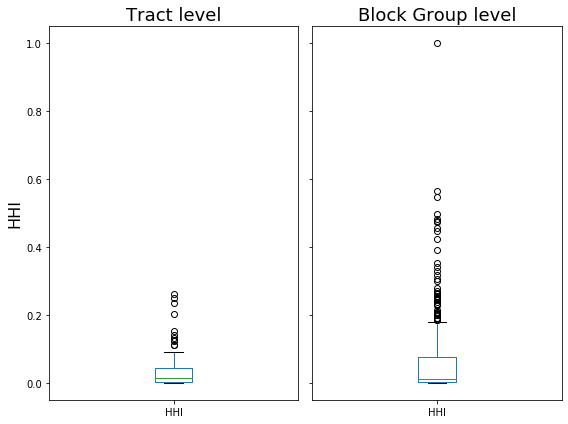

In [41]:
fig, axes = plt.subplots(1,2, sharey=True)
fig.set_figwidth(8)
fig.set_figheight(6)

tractHHIs.HHI.plot(kind='box', ax=axes[0])
axes[0].set_title("Tract level", fontsize=18)
axes[0].set_ylabel("HHI", fontsize=16)

bgHHIs.HHI.plot(kind='box', ax=axes[1])
axes[1].set_title("Block Group level", fontsize=18)
axes[1].set_ylabel("HHI", fontsize=16)

plt.tight_layout()

# Merge TIGER data with HHI output

In [42]:
## TIGER data
bgshp = gpd.read_file("/".join([data_path, 'tl_2010_37183_bg10','tl_2010_37183_bg10.shp']))
tractshp = gpd.read_file("/".join([data_path, 'tl_2010_37183_tract10','tl_2010_37183_tract10.shp']))

In [43]:
# drop superfluous columns
cols2drop = ['NAMELSAD10', 'MTFCC10', 'FUNCSTAT10', 'ALAND10', 'AWATER10',
       'INTPTLAT10', 'INTPTLON10']

for tmp in [bgshp, tractshp]:
    tmp.drop(cols2drop,axis=1,inplace=True)

In [44]:
bgshp.loc[:,'GEOID10'] = bgshp.GEOID10.astype(np.float)

# merge block group shapes to data
bgHHIs = bgHHIs.merge(bgshp, left_index=True,right_on='GEOID10',how='left')

In [45]:
# merger with tiger data
tractshp.loc[:,'TRACTCE10'] = tractshp.TRACTCE10.astype(np.int)
tractHHIs = tractHHIs.merge(tractshp, left_index=True, right_on='TRACTCE10', how='left')

In [48]:
def labelMaker(cuts):
    labs = []
    for i in range(len(cuts)-1):
        #print(i)
        labs.append("%.03f - %.03f" %(cuts[i],cuts[i+1]))
    return(labs)   

In [49]:
for tmp in [tractHHIs, bgHHIs]:
    qcuts = np.array([0,.1,.2,.5,1])#tmp.HHI.quantile(np.arange(0,1.2,.2)).round(3)
    tmp.loc[:,'qcuts'] = pd.cut(tmp.HHI, qcuts, labels = labelMaker(qcuts)).astype('str')

In [50]:
tractHHIs.qcuts.unique()

array(['0.000 - 0.100', '0.200 - 0.500', '0.100 - 0.200'], dtype=object)

In [51]:
bgHHIs.qcuts.unique()

array(['0.000 - 0.100', '0.200 - 0.500', '0.100 - 0.200', '0.500 - 1.000'],
      dtype=object)

In [52]:
for tmp,key in zip([tractHHIs,bgHHIs],['tract','bg']):
    gpd.GeoDataFrame(tmp, crs = bgshp.crs).to_file("/".join([data_path, "wake_cnty_%s_hhi.shp" %key ]))